Dataset downloaded from https://www.kaggle.com/amananandrai/ag-news-classification-dataset

In [30]:
import os
import pandas as pd
import json
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.layers import concatenate
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [86]:
df = pd.read_csv('train.csv')

We'll use regex to perform some data cleaning on the escape characters and random symbols floating around.

In [88]:
df['Description'] = df['Description'].str.replace('(?:&)(.){1,4};', '', regex=True)
df['Description'] = df['Description'].str.replace('(?:#)(.){1,4};', '', regex=True)
df['Description'] = df['Description'].str.replace('b.../b', '', regex=True)
df['Description'] = df['Description'].str.replace(' s ', '', regex=True)
df['Description'] = df['Description'].str.replace('fullquote', '', regex=True)
df['Description'] = df['Description'].str.replace('aspx', '', regex=True)
df['Description'] = df['Description'].str.replace('(?:quot;).*quot;', '', regex=True)
df['Description'] = df['Description'].str.replace('//', ' ', regex=True)
df['Description'] = df['Description'].str.replace('\\', ' ', regex=True)

In [89]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


By performing a word count we can see the extent to which "stop" words are featured in the text.

In [73]:
text = ' '.join(df['Description']).lower()
split_it = text.split()
counts = Counter(split_it)
counts = counts.most_common(20)
print(counts)

[('the', 196092), ('a', 104041), ('to', 94737), ('of', 88345), ('in', 77494), ('and', 65160), ('on', 46737), ('-', 38008), ('for', 37548), ('that', 26778), ('with', 22438), ('as', 21604), ('its', 21029), ('at', 20610), ('is', 19542), ('by', 18520), ('has', 18129), ('new', 16744), ('it', 16514), ('said', 16380)]


We've already loaded a list of stop words to removed from the word cloud, but there are a couple more we should add.

In [74]:
STOPWORDS.add('u')
STOPWORDS.add('s')
STOPWORDS.add('said')

(-0.5, 2999.5, 1999.5, -0.5)

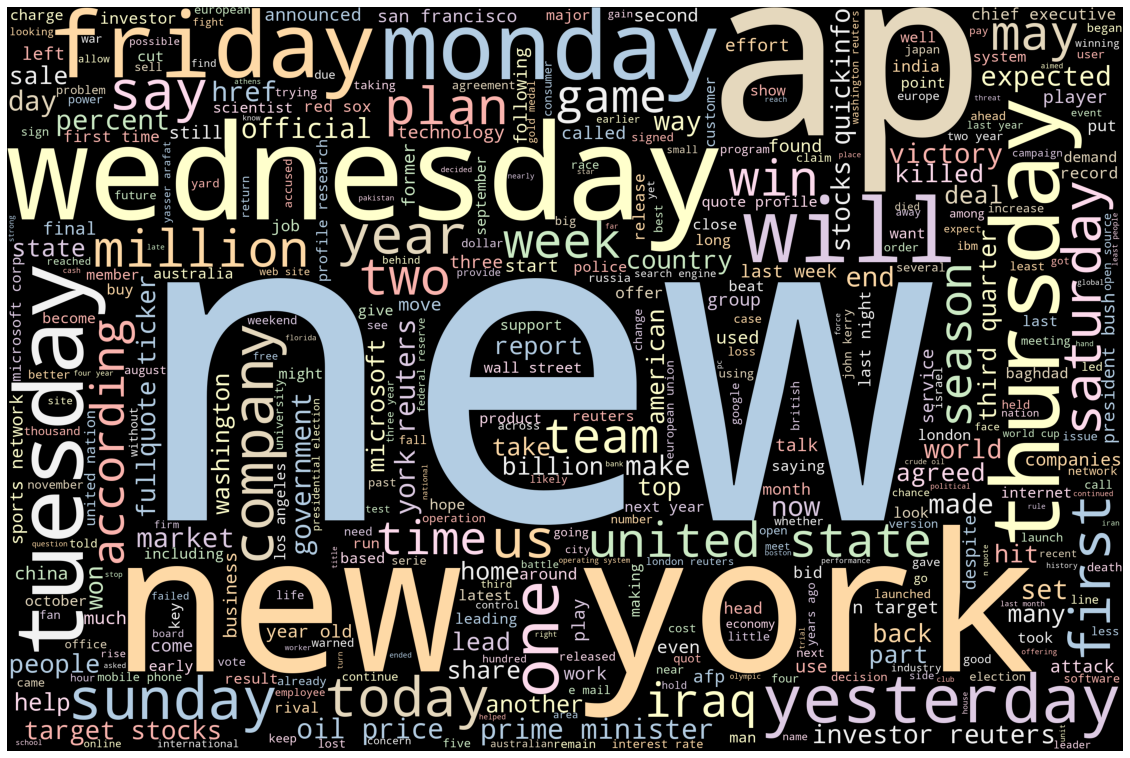

In [75]:
wordcloud = WordCloud(
    width= 3000, 
    height = 2000, 
    max_words = 400, 
    colormap='Pastel1', 
    stopwords = STOPWORDS).generate(text)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud) 
plt.axis("off")

Our dataframe contains four classes of article, each with the same amount of entries:

In [76]:
df['Class Index'].value_counts()

1    30000
2    30000
3    30000
4    30000
Name: Class Index, dtype: int64

You can explore the word distributions for each article class, by feeding in any of these dataframes into the word cloud.

In [77]:
world = df[df['Class Index'] == 1]
sports = df[df['Class Index'] == 2]
business = df[df['Class Index'] == 3]
sci = df[df['Class Index'] == 4]



In [15]:
world_lengths = world['Description'].apply(lambda x: len(x))
sports_lengths = sports['Description'].apply(lambda x: len(x))
business_lengths = business['Description'].apply(lambda x: len(x))
sci_lengths = sci['Description'].apply(lambda x: len(x))

How many words does each article type have? We can use histograms to visualize any differences

Populating the interactive namespace from numpy and matplotlib


/Users/jeremy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sci', 'concatenate', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


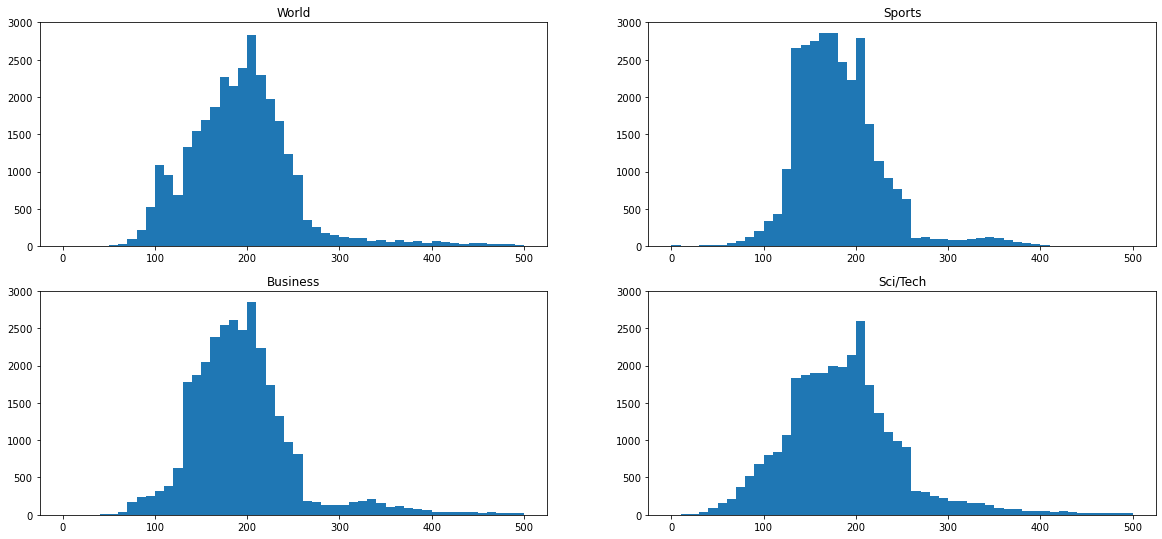

In [16]:
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 14)

dfs = [world_lengths, sports_lengths, business_lengths, sci_lengths]
titles = ['World', 'Sports', 'Business', 'Sci/Tech']

plot_num = 1

for i in range(len(dfs)):
    fig = plt.subplot(3,2,plot_num)

    axes = plt.gca()
    axes.set_ylim([0,3000])
    one_cat = dfs[i]
    plt.hist(one_cat, bins=50, range=(0,500))
    title = plt.gca().set_title(titles[i])
    plot_num += 1
    
plt.show()

In [17]:
print('Average world article length:', int(round(world_lengths.mean(), 0)))
print('Average sport article length:', int(round(sports_lengths.mean(), 0)))
print('Average business article length:', int(round(business_lengths.mean(), 0)))
print('Average sci/tech article length:', int(round(sci_lengths.mean(), 0)))

Average world article length: 193
Average sport article length: 181
Average business article length: 195
Average sci/tech article length: 190


Now, let's actually start building the model itself. We'll keep track of hyperparameters and other useful details related to this run in a text log. Let's define these values as constants here.

In [57]:
NOTES = ''
LEN = len(df)
SPLIT = 0.9
LAYERS = 2
DROPOUT = 0.5
BATCH = 100
EPOCHS = 15
SMOOTHING = 0.1
NODES_1 = 100
NODES_2 = 32
NODES_3 = 0

The dataframe has two text columns. We could concatenate them together as a single entry, but common sense tells us they are qualitatively different fields that have their own separate word distributions. Let's build a concetenation model to treat both fields as separate features.

The singular feature for the left branch of the model is stored in the variable X. This feature is the text of the article itself, whereas the feature X2 is the article title. The one-hot encoded output variable Y, will be used by both branches.

In [58]:
X = df['Description']
Y = pd.get_dummies(df['Class Index'])

X2 = df['Title']

This cell will tokenize both features in two separate variables.

In [59]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=None)

encoder.adapt(X)

encoder2 = tf.keras.layers.TextVectorization(
    max_tokens=None)

encoder2.adapt(X2)

This cell will construct the left branch, for the article text.

In [60]:
mod = tf.keras.Sequential()

mod.add(tf.keras.Input(shape=(1,), dtype=tf.string))
mod.add(encoder)
mod.add(tf.keras.layers.Embedding(len(encoder.get_vocabulary()), NODES_1, mask_zero=True))
mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_1,  return_sequences=True)))
mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_2)))

This cell will construct the right branch, for the article title.

In [61]:
mod2 = tf.keras.Sequential()

mod2.add(tf.keras.Input(shape=(1,), dtype=tf.string))
mod2.add(encoder2)
mod2.add(tf.keras.layers.Embedding(len(encoder.get_vocabulary()), NODES_1, mask_zero=True))
mod2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_1,  return_sequences=True)))
mod2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_2)))

This cell will concatenate both branches together and compile the model. Note the input and output structure.

In [62]:
model_concat = concatenate([mod.output,mod2.output])
model_concat = tf.keras.layers.Dense(NODES_2, activation='relu')(model_concat)
model_concat = tf.keras.layers.Dropout(DROPOUT)(model_concat)
model_concat = tf.keras.layers.Dense(Y.shape[1], activation='softmax')(model_concat)

model = Model(inputs=[mod.input, mod2.input], outputs=model_concat)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=SMOOTHING, from_logits=False),
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=([tf.keras.metrics.CategoricalCrossentropy(name='CatCrossentropy'), 
            tf.keras.metrics.CategoricalAccuracy(name='CatAccuracy'),
            tf.keras.metrics.Recall(name='Recall')]))

We can use a graph visualization of the model to get a better idea of what is going on here.

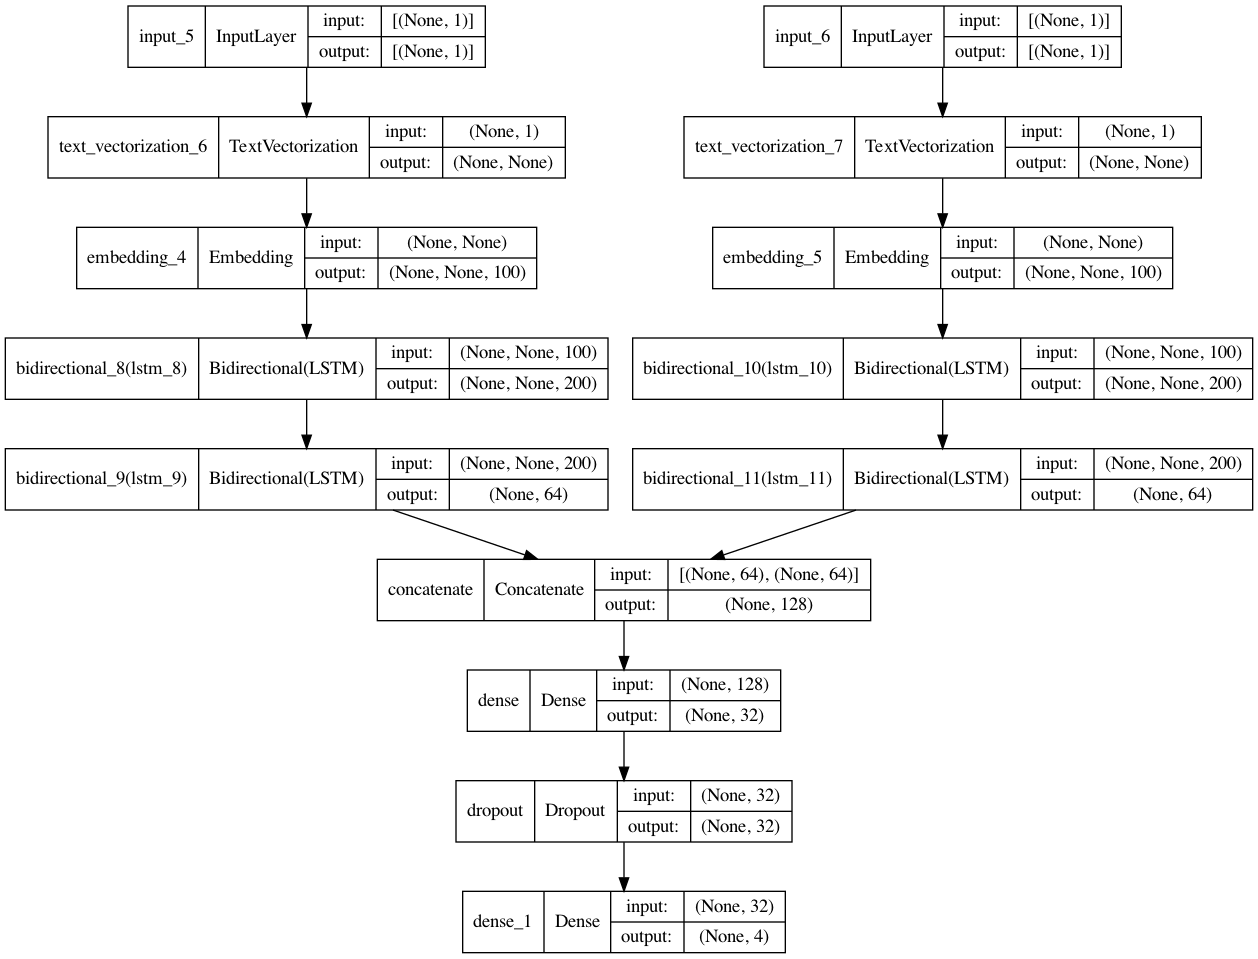

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [63]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_8 (TextVect  (None, None)        0           ['input_9[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_9 (TextVect  (None, None)        0           ['input_10[0][0]']         

In [64]:
history = model.fit(x=[X.values, X2.values], y=Y.values, batch_size = BATCH, epochs=EPOCHS,
    validation_split=SPLIT, verbose=True)

Epoch 1/15
120/120 [==============================] - 163s 1s/step - loss: 1.3802 - CatCrossentropy: 1.3795 - CatAccuracy: 0.3641 - Recall: 0.0000e+00 - val_loss: 1.3668 - val_CatCrossentropy: 1.3646 - val_CatAccuracy: 0.5938 - val_Recall: 0.0000e+00
Epoch 2/15
120/120 [==============================] - 127s 1s/step - loss: 1.1376 - CatCrossentropy: 1.0862 - CatAccuracy: 0.6184 - Recall: 0.1960 - val_loss: 0.9085 - val_CatCrossentropy: 0.8132 - val_CatAccuracy: 0.7438 - val_Recall: 0.4903
Epoch 3/15
120/120 [==============================] - 126s 1s/step - loss: 0.7682 - CatCrossentropy: 0.6066 - CatAccuracy: 0.8208 - Recall: 0.6741 - val_loss: 0.7817 - val_CatCrossentropy: 0.6360 - val_CatAccuracy: 0.7892 - val_Recall: 0.6931
Epoch 4/15
120/120 [==============================] - 126s 1s/step - loss: 0.6407 - CatCrossentropy: 0.4311 - CatAccuracy: 0.8942 - Recall: 0.8061 - val_loss: 0.7575 - val_CatCrossentropy: 0.5869 - val_CatAccuracy: 0.7988 - val_Recall: 0.7452
Epoch 5/15
120/120 [

In [65]:
pred = model.predict([df['Description'], df['Title']])
pred = pd.Series(np.argmax(pred, axis=1))
pred += 1
df['pred'] = pred


ACC = len(df[df['pred']==df['Class Index']])/len(df)
print(ACC)

0.8062083333333333


In [69]:
world = df[df['Class Index']==1]
world_acc = len(world[world['pred']==1])/len(world)
sports = df[df['Class Index']==2]
sports_acc = len(sports[sports['pred']==2])/len(sports)
business = df[df['Class Index']==3]
business_acc = len(business[business['pred']==3])/len(business)
sci = df[df['Class Index']==4]
sci_acc = len(sci[sci['pred']==4])/len(sci)

print('Accuracy on world articles:', round(world_acc, 2))
print('Accuracy on sports articles:', round(sports_acc, 2))
print('Accuracy on business articles:', round(business_acc, 2))
print('Accuracy on science/tech articles:', round(sci_acc, 2))

Accuracy on world articles: 0.79
Accuracy on sports articles: 0.84
Accuracy on business articles: 0.76
Accuracy on science/tech articles: 0.84


In [70]:
row = {'accuracy': ACC, 'notes': NOTES, 'len': LEN,
    'split': SPLIT, 'layers': LAYERS, 'dropout': DROPOUT,
    'batch': BATCH, 'epochs': EPOCHS, 'smoothing': SMOOTHING,
    'nodes1': NODES_1, 'nodes2': NODES_2, 'nodes3': NODES_3}

print(row)

{'accuracy': 0.8062083333333333, 'notes': '', 'len': 120000, 'split': 0.9, 'layers': 2, 'dropout': 0.5, 'batch': 100, 'epochs': 15, 'smoothing': 0.1, 'nodes1': 100, 'nodes2': 32, 'nodes3': 0}


I find it helpful to log each training session and the results to compare hyperparameters and other details.

In [ ]:
log = pd.read_csv('text_and_title.csv')
log = log.append(row, ignore_index=True)
log.to_csv('text_and_title.csv', index=False)

This model gets a max accuracy of .81, versus 0.78 for the description-only model. Not extraordinary, but it's not nothing!